# Experiment with U-net segmentation

Import packages

In [6]:
import os
import random
import sys

sys.path.append(os.path.abspath(".."))

from PIL import Image, ImageOps
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2

from tensorflow.keras.preprocessing.image import load_img, img_to_array

from segmentation.ml_logic.preprocessor import Preprocessor

Define directories for dataset

In [8]:
image_dir1 = "../raw_data/segmentation/TIFF"
mask_dir1 = "../raw_data/segmentation/Mask"

image_dir2 = "../raw_data/classification/test"

IMG_SIZE = (224, 224)

In [9]:
VALID_IMAGE_EXTENSIONS = ('.jpg', '.jpeg', '.png', '.bmp', '.tif', '.tiff')

def load_data(image_dir, mask_dir, image_size=IMG_SIZE):
    images, masks = [], []
    preproc = Preprocessor()
    for filename in os.listdir(image_dir):
        if not filename.lower().endswith(VALID_IMAGE_EXTENSIONS):
            continue  # Skip non-image files
        img_path = os.path.join(image_dir, filename)
        mask_path = os.path.join(mask_dir, filename)
        
        try:
            # Load image
            img = Image.open(img_path).convert("RGB").resize(image_size)
            if preproc.is_black_on_white(img_to_array(img)):
                img = ImageOps.invert(img)
            
            img = img_to_array(img)/255
            
            #Load mask or create blank
            if os.path.exists(mask_path):
                mask = load_img(mask_path, target_size=image_size, color_mode="grayscale")
                mask = img_to_array(mask) / 255.0
                mask = np.round(mask)
            else:
                mask = np.zeros((image_size[0], image_size[1], 1), dtype=np.float32)

            images.append(img)
            #import ipdb; ipdb.set_trace()
            masks.append(mask)
        
        
        except Exception as e:
            print(f"Skipping {filename}: {e}")
    
    return np.array(images), np.array(masks)

In [10]:
# def load_X(image_dir, image_size=IMG_SIZE):
#     images = []
#     preproc = Preprocessor()

#     for root, _, files in os.walk(image_dir):  # recursively walk through subdirs
#         for filename in files:
#             if not filename.lower().endswith(VALID_IMAGE_EXTENSIONS):
#                 continue  # Skip non-image files

#             img_path = os.path.join(root, filename)

#             try:
#                 # Load image and preprocess
#                 img = Image.open(img_path).convert("RGB").resize(image_size)
#                 if preproc.is_black_on_white(img_to_array(img)):
#                     img = ImageOps.invert(img)

#                 img = img_to_array(img) / 255.0
#                 images.append(img)

#             except Exception as e:
#                 print(f"Skipping {img_path}: {e}")

#     return np.array(images)

In [11]:
X, y = load_data(image_dir1, mask_dir1)
X.shape

(511, 224, 224, 3)

In [6]:
# X_test = load_X(image_dir2)
# X_test.shape

(336, 224, 224, 3)

Visualize an image

Image shape after reading: (512, 512, 4)
Maximum pixel value after reading: 255.0
Minimum pixel value after reading: 0.0
Image dtype after reading: float32
Image shape after normalization: (512, 512, 4)
Maximum pixel value after normalization: 255
Minimum pixel value after normalization: 0
Image dtype after normalization: uint8
Image shape after grayscale: (512, 512)
Maximum pixel value after grayscale: 243
Minimum pixel value after grayscale: 0
Image dtype after grayscale: uint8
Image shape after 2. inversion: (512, 512)
Image dtype after 2. inversion: uint8
Image shape after 3. breast region detection: (435, 285)
Image dtype after 3. breast region detection: uint8
Image dtype before 5. CLAHE: uint8
Image shape after 5. CLAHE: (435, 285)
Maximum pixel value after 5. CLAHE: 252
Minimum pixel value after 5. CLAHE: 2
Image dtype after 5. CLAHE: uint8
Image shape after 4. normalization: (435, 285)
Maximum pixel value after 4. normalization: 1.0
Minimum pixel value after 4. normalization: 

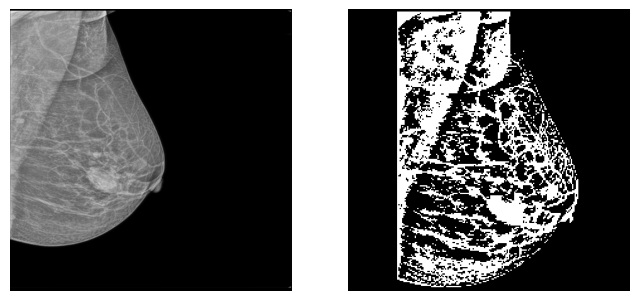

In [62]:
#sample_image_path = image_dir2 + "/1/2489_57015221_png.rf.35100e4139158a64e5c05e48ba5e1add.jpg"
sample_image_path = image_dir1 + "/IMG001.png"
preproc = Preprocessor()

sample_image = Image.open(sample_image_path)
image_array = img_to_array(sample_image)

preproc_image = preproc.preprocess_image(image_array)
preproc_image2 = Image.fromarray(preproc_image)


#Plot
plt.figure(figsize=(8, 4)) 
plt.subplot(1, 2, 1)
plt.imshow(sample_image)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(preproc_image2)
plt.axis('off')  
plt.show()

## Load model

In [43]:
from tensorflow.keras.models import load_model
threshold = 0.8

model = load_model("../models/segmentation/unet_seg_model_11_6_2025_2.keras", compile = False)

In [33]:
X_test[np.random.choice(len(X_test), size=10, replace=True)].shape

(10, 224, 224, 3)

In [44]:
#preds = model.predict(X_test[np.random.choice(len(X_test), size=10, replace=True)])
preds = model.predict(X_test[0:20])
preds_binary = (preds > threshold).astype(np.uint8)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


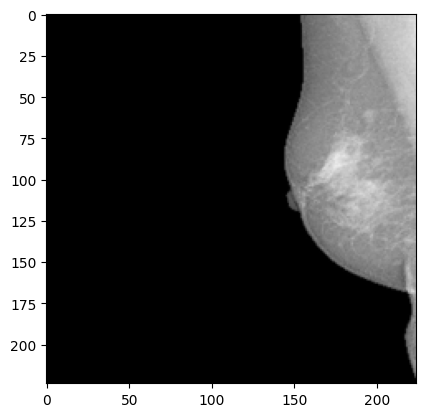

In [45]:
plt.imshow(X_test[0])

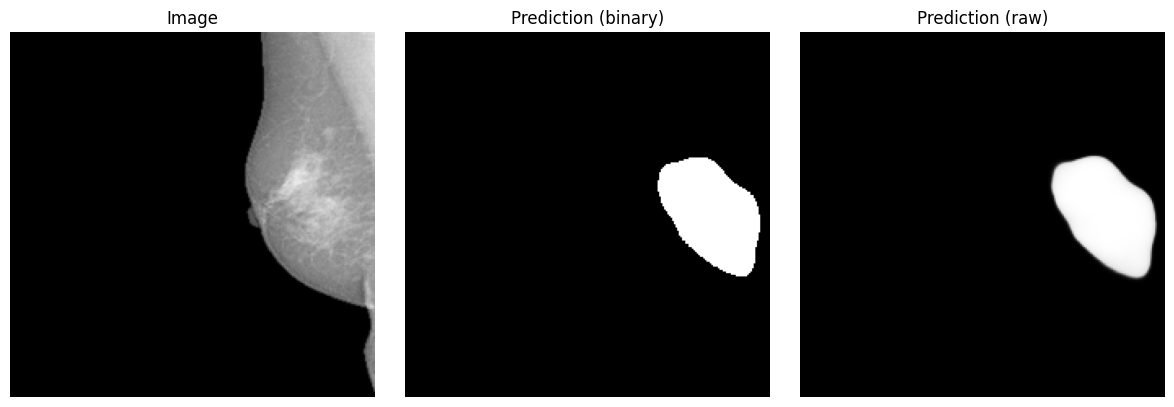

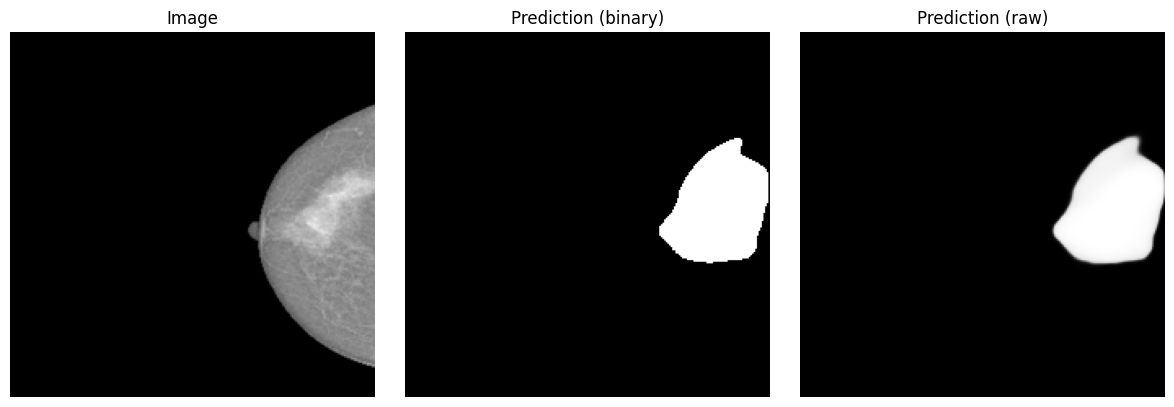

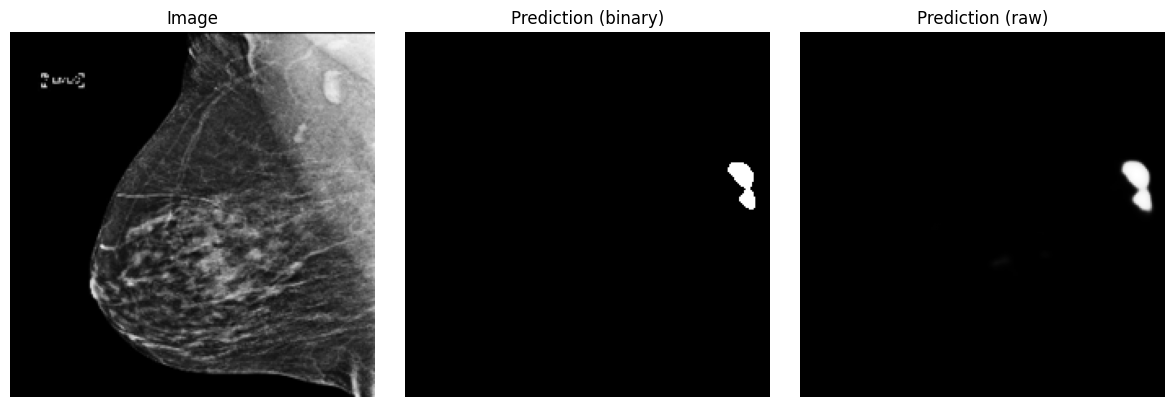

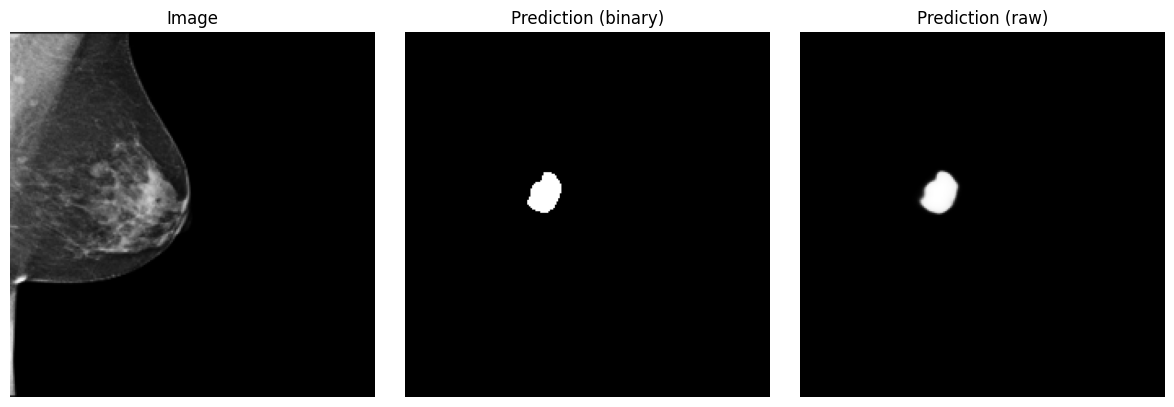

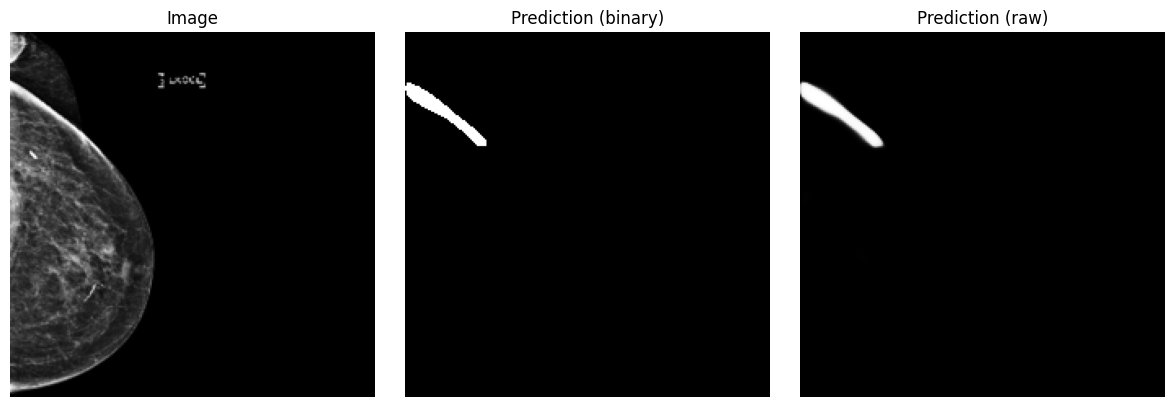

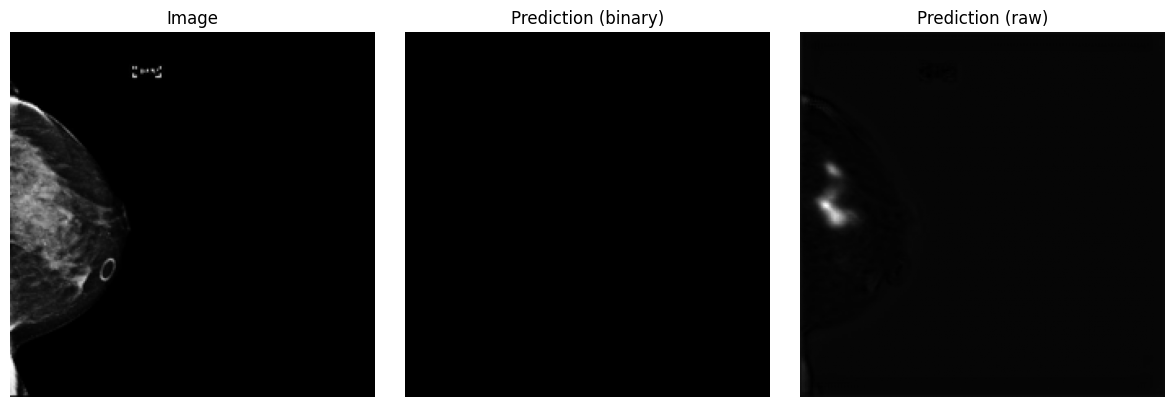

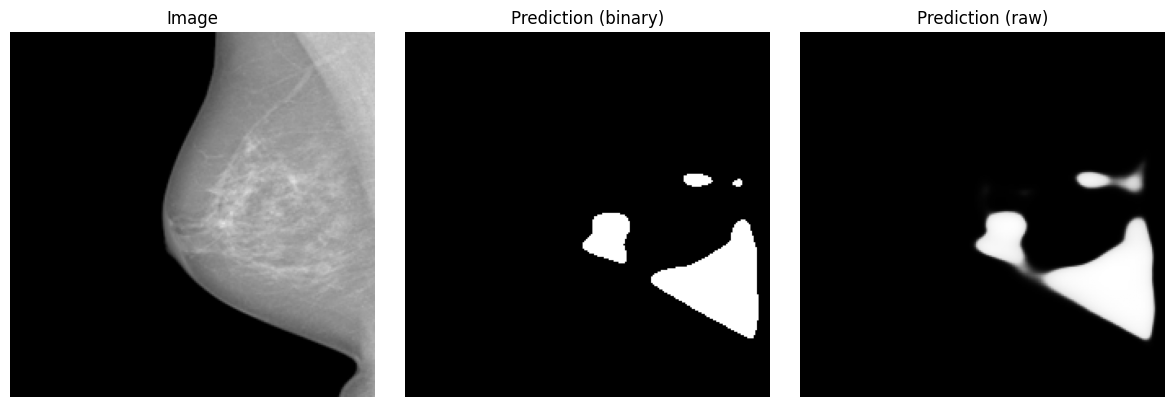

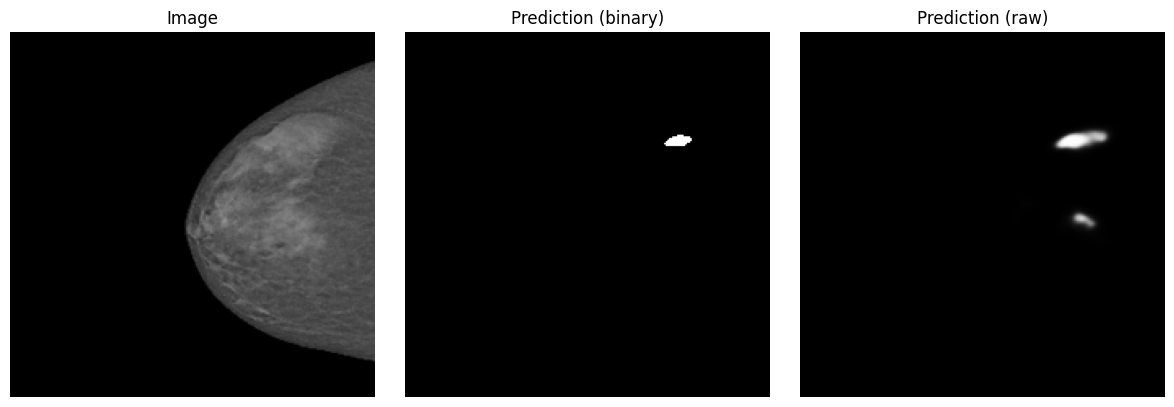

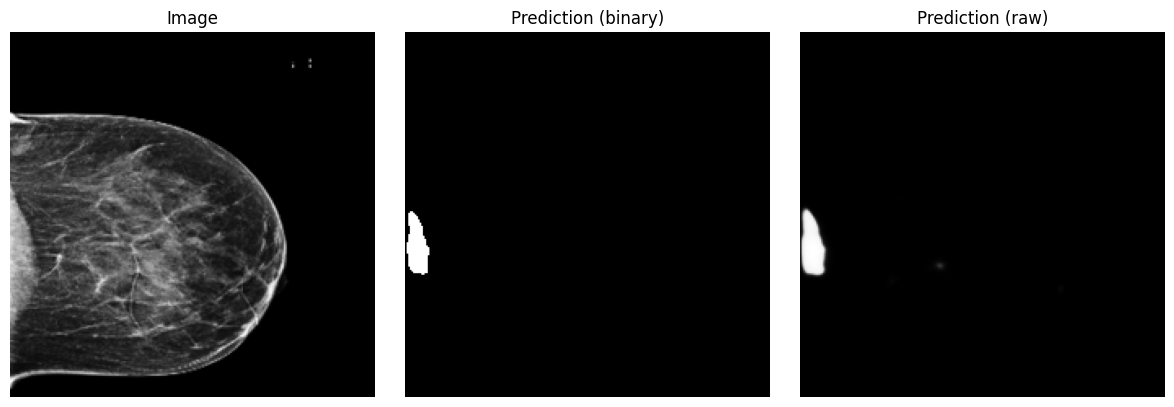

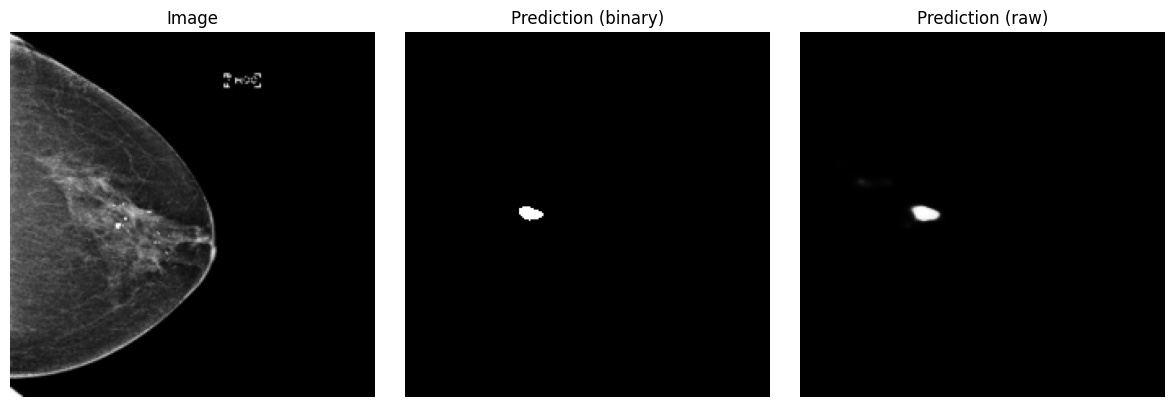

In [46]:
for i in range(0, 10):
    plt.figure(figsize=(12, 4))  # Wider figure to fit 4 subplots

    plt.subplot(1, 3, 1)
    plt.imshow(X_test[i])
    plt.title("Image")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(preds_binary[i].squeeze(), cmap='gray')
    plt.title("Prediction (binary)")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(preds[i].squeeze(), cmap='gray')
    plt.title("Prediction (raw)")
    plt.axis('off')
    

    plt.tight_layout()
    plt.show()

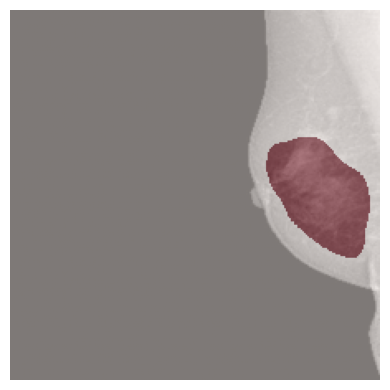

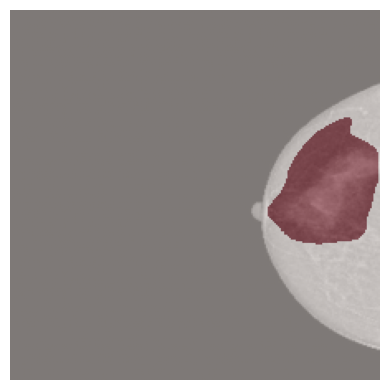

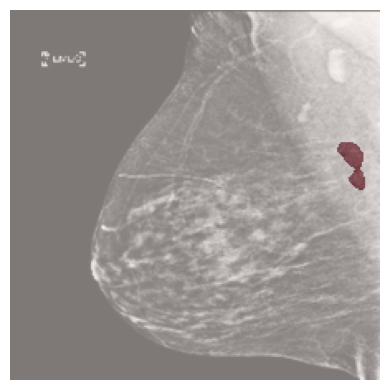

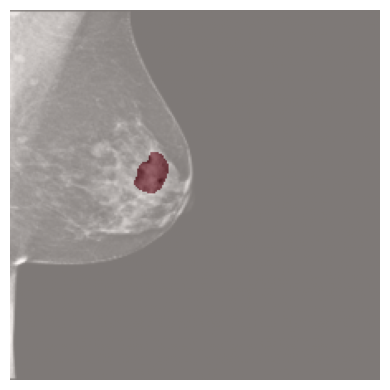

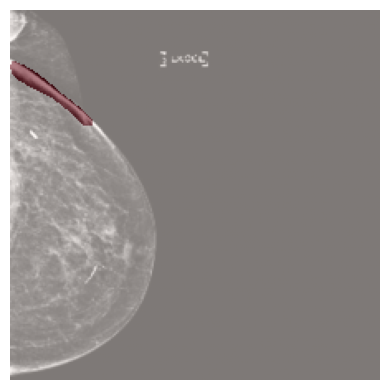

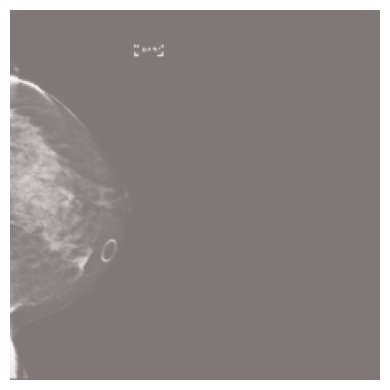

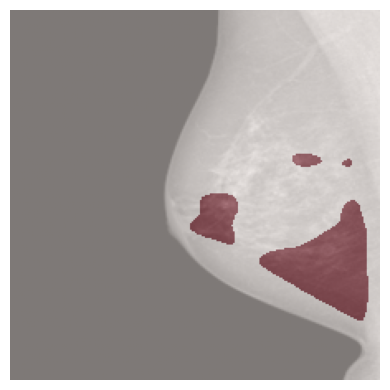

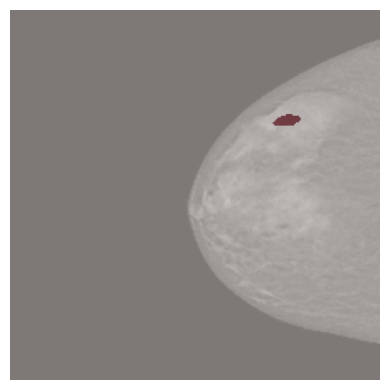

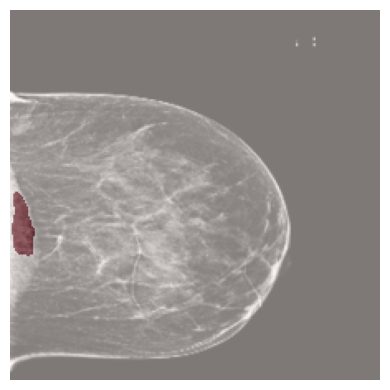

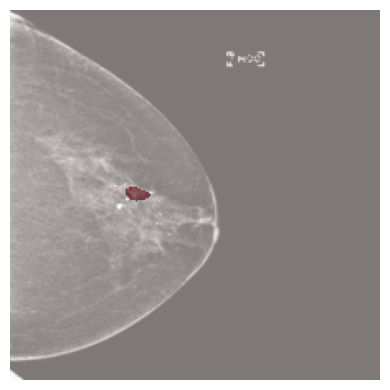

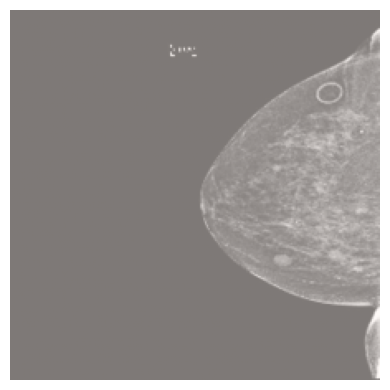

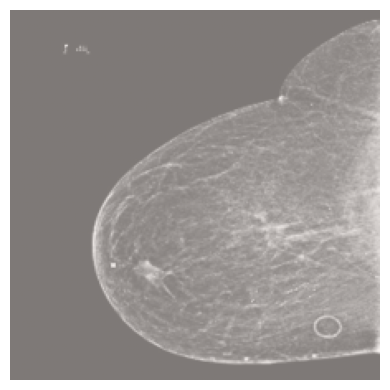

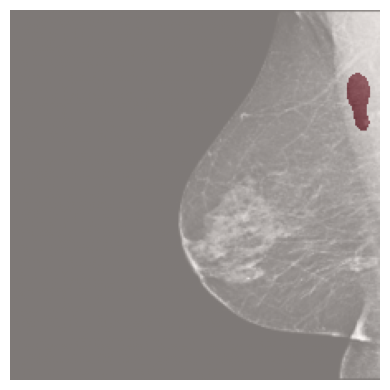

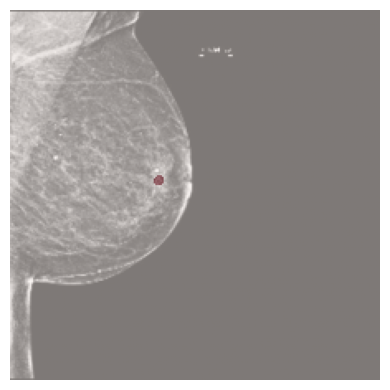

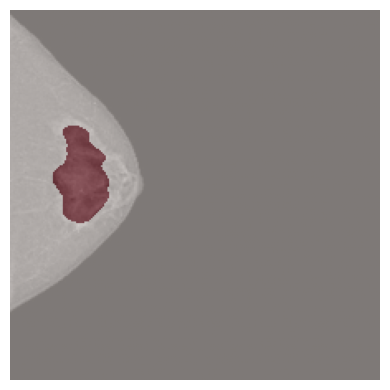

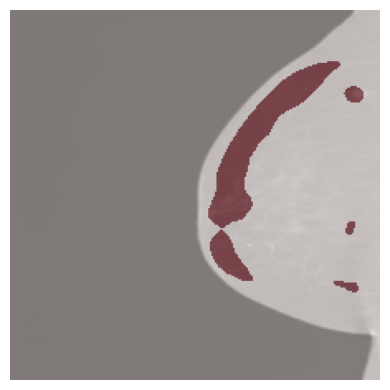

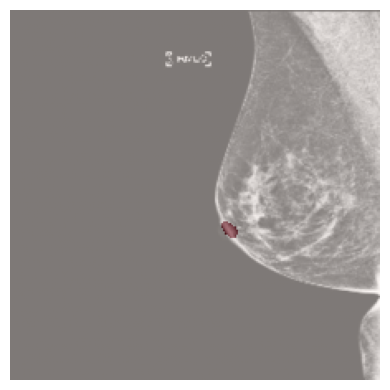

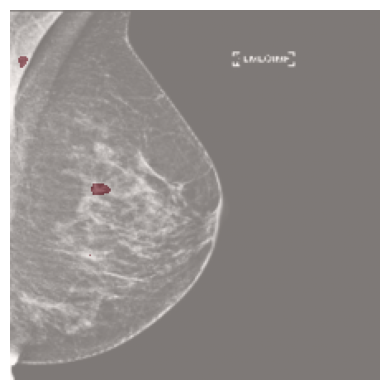

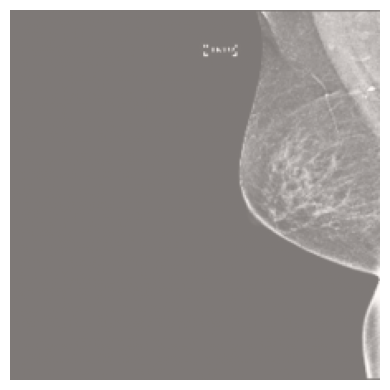

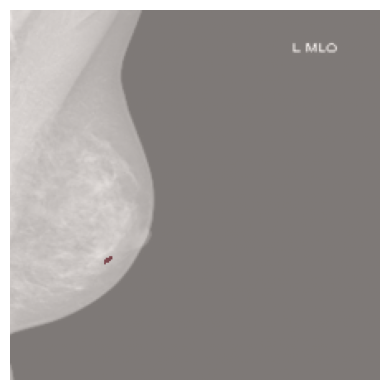

In [47]:
def plot_overlay(image, mask, alpha=0.5, mask_color='Reds'):
    """
    image: numpy array, shape (H, W, 3)
    mask: numpy array, shape (H, W) or (H, W, 1)
    alpha: transparency of the mask overlay
    mask_color: colormap for the mask (e.g., 'Reds', 'Greens', 'jet')
    """
    
    plt.imshow(image)
    plt.imshow(mask.squeeze(), cmap=mask_color, alpha=alpha)
    plt.axis('off')
    
    
#for i in random.sample(range(1, len(X_test)), 5):
for i in range(len(preds)):
    plt.figure(figsize=(4, 4))
    
    plot_overlay(X_test[i], preds_binary[i])          # Binary prediction
    #plt.subplot(1, 3, 3)
    #plot_overlay(X[i], preds[i], alpha=0.3)      # Soft prediction
    
    plt.tight_layout()
    plt.show()